In [1]:
import numpy as np
import tqdm
from tqdm import trange
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from torch import nn
from torch.optim import Adam
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
iris = load_iris()
X = iris.data[:50]
Y = iris.target[:50]
Xd, Xt, Yd, Yt = train_test_split(X, Y, test_size=0.2, random_state=0)

In [3]:
for i,(x,y) in enumerate(zip(Xd,Yd)):
    print(x,y)
    if i==5:
        break

[5.5 4.2 1.4 0.2] 0
[5.  3.2 1.2 0.2] 0
[5.  3.4 1.6 0.4] 0
[4.9 3.1 1.5 0.2] 0
[5.7 3.8 1.7 0.3] 0
[5.  3.4 1.5 0.2] 0


In [4]:
N = len(Xd[0])

In [21]:
# class QNN(nn.Module):
#     def __init__(self):
#         super(QNN, self).__init__()
#         self.qc = QuantumCircuit(N, 1)
#         self.qc.h(range(N))
#         self.qc.barrier()
#         self.qc.ry(np.pi/2, range(N))
#         self.qc.barrier()
#         self.qc.measure(range(N), range(N))
    
#     def forward(self, x):
#         x = Statevector.from_label(x)
#         qc = self.qc.copy()
#         qc.initialize(x.data, range(N))
#         backend = Aer.get_backend('statevector_simulator')
#         result = backend.run(qc).result().get_counts()
#         result = np.array([result[i] for i in range(N)])
#         return result


In [22]:
#qnn = QNN()

In [12]:
def encode_data(X):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    
    qc = QuantumCircuit(q, c)
    for i, x in enumerate(X):
        qc.rx(x,i)
    return qc, c

In [13]:
def variational_circuit(qc, theta):
    for i in range(N-1):
        qc.cx(i, i+1)
    qc.cx(N-1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
        
    return qc

In [14]:
def neural_net(x, theta, simulator = True):
    qc, c = encode_data(x)
    qc = variational_circuit(qc, theta)
    qc.measure(0, c)
    
    shots = 1000
    backend = Aer.get_backend('qasm_simulator')

    job = backend.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts['1']/shots, qc

In [15]:
def loss_fn(y_pred, y_true):
    return (y_pred - y_true)**2

In [16]:
def grad_fn(x, y, theta):
    h = 0.01
    grad = np.zeros(N)
    for i in range(N):
        theta[i] += h
        y_pred, _ = neural_net(x, theta)
        l1 = loss_fn(y_pred, y)
        
        theta[i] -= 2*h
        y_pred, _ = neural_net(x, theta)
        l2 = loss_fn(y_pred, y)
        
        grad[i] = (l1 - l2)/(2*h)
        theta[i] += h
    return grad

In [17]:
def accuracy(X, Y, theta):
    correct = 0
    for x, y in zip(X, Y):
        y_pred,_ = neural_net(x, theta)
        if y_pred > 0.5:
            y_pred = 1
        else:
            y_pred = 0
        if y_pred == y:
            correct += 1
    return correct/len(Y)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:22<00:00,  2.62s/it, Loss=9.54, Accuracy=1] 


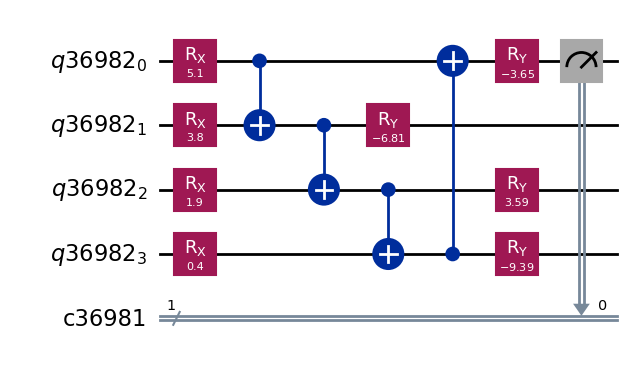

In [18]:
learning_rate = 0.1
loss_list = []
theta = np.random.rand(N)
epochs = 100
t = trange(epochs,desc="")
qc = QuantumCircuit(N)
for epoch in t:
    loss = 0
    for x, y in zip(Xd, Yd):
        y_pred, qc = neural_net(x, theta)
        loss += loss_fn(y_pred, y)
        grad = grad_fn(x, y, theta)
        theta -= learning_rate*grad
        
    loss_list.append(loss)
    t.set_postfix({'Loss': loss, 'Accuracy': accuracy(Xt, Yt, theta)})
qc.draw(output='mpl')

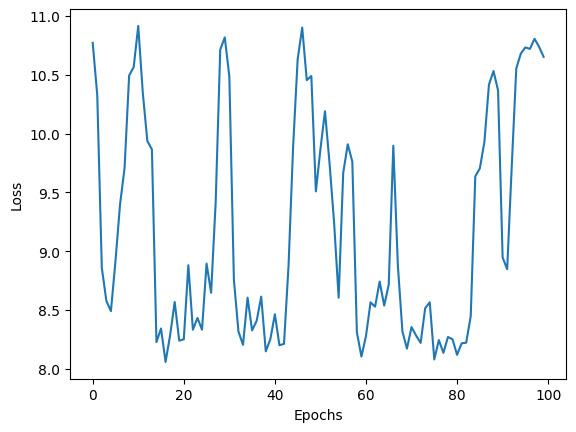

In [67]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Accuracy: 0.7692307692307693


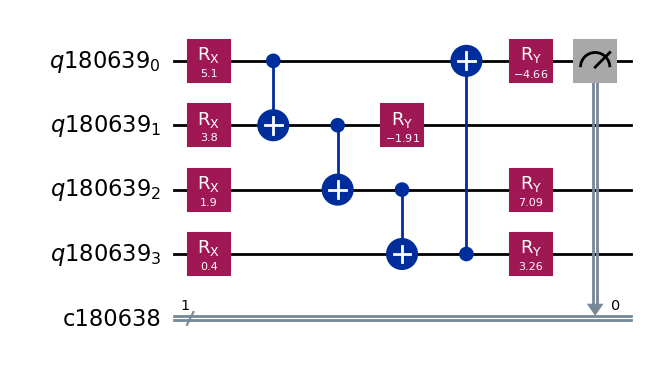

In [68]:
# Test the model
correct = 0
for x, y in zip(Xt, Yt):
    y_pred,_ = neural_net(x, theta)
    if y_pred > 0.5:
        y_pred = 1
    else:
        y_pred = 0
    if y_pred == y:
        correct += 1
print(f'Accuracy: {correct/len(Yt)}')
qc.draw(output='mpl')